In [1]:
import torch
import pandas as pd
import time
import ast
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english') + stopwords.words('spanish'))


In [37]:
import string

In [3]:
import networkx as nx
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np


/home/bowenyi/.local/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
en_data = pd.read_csv("en.csv")

In [5]:
es_data = pd.read_csv("es.csv")

In [6]:
en_data.columns

Index(['id', 'text', 'lang', 'epoch', 'hashtags', 'links', 'replyCount',
       'retweetCount', 'likeCount', 'quoteCount', 'conversationId',
       'mentionedUsers', 'id_str', 'followersCount', 'friendsCount',
       'statusesCount'],
      dtype='object')

In [7]:
def convert_format(field):
    return ast.literal_eval(field)

en_data['hashtags'] = en_data['hashtags'].apply(convert_format)
en_data['links'] = en_data['links'].apply(convert_format)
en_data['mentionedUsers'] = en_data['mentionedUsers'].apply(convert_format)

es_data['hashtags'] = es_data['hashtags'].apply(convert_format)
es_data['links'] = es_data['links'].apply(convert_format)
es_data['mentionedUsers'] = es_data['mentionedUsers'].apply(convert_format)


#### To decrease the runtime, plan to filter out users that have shared fewer than 10 tweets

In [30]:
# Text
es_text_map = es_data.groupby('id_str')['text'].apply(list)
en_text_map = en_data.groupby('id_str')['text'].apply(list)

es_10_tweet = sum(len(texts) >= 10 for texts in es_text_map)
en_10_tweet = sum(len(texts) >= 10 for texts in en_text_map)
print(f"Number of users with more than 10 tweets in Spanish: {es_10_tweet}")
print(f"Number of users with more than 10 tweets in English: {en_10_tweet}")


Number of users with more than 10 tweets in Spanish: 4773
Number of users with more than 10 tweets in English: 2162


### Text similarity network construction

#### 1. Cleaning text

In [33]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove emojis
    text = text.encode("ascii", "ignore").decode("utf-8")
    # Tokenize and remove stopwords
    words = word_tokenize(text.lower())
    words = [word for word in words if word not in stop_words]

    return " ".join(words)
    

#### 2. Network construction

In [28]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2").to(device)

/home/bowenyi/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [31]:
# English only
def construct_text_similarity_network_en(dataframe, threshold=0.7):
    # Step 1: Clean the text column
    dataframe['cleaned_text'] = dataframe['text'].apply(clean_text)
    
    # Step 2: Filter out tweets with fewer than 4 words
    dataframe = dataframe[dataframe['cleaned_text'].apply(lambda x: len(x.split()) >= 4)]
    
    # Step 3: Group tweets by user
    user_text_map = dataframe.groupby('id_str')['cleaned_text'].apply(list)
    user_text_map = {user: texts for user, texts in user_text_map.items() if len(texts) >= 10}

    # Step 4: Generate embeddings for each user
    user_embeddings = {}
    for i, (user, texts) in enumerate(user_text_map.items()):
        # Encode all texts for the user
        embeddings = model.encode(texts, device='cuda', batch_size=64)
        # Average embeddings to get a single user-level vector
        user_embeddings[user] = np.mean(embeddings, axis=0)

    # Step 5: Compute cosine similarity matrix
    user_ids = list(user_embeddings.keys())
    user_vectors = np.array(list(user_embeddings.values()))
    similarity_matrix = cosine_similarity(user_vectors)

    # Step 6: Build the user-user similarity graph
    G = nx.Graph()
    for i, user1 in enumerate(user_ids):
        for j, user2 in enumerate(user_ids):
            if i != j and similarity_matrix[i, j] > threshold:
                G.add_edge(user1, user2, weight=similarity_matrix[i, j])

    return G

In [38]:
en_text_graph = construct_text_similarity_network_en(en_data)


In [44]:
en_text_graph.size()

312579

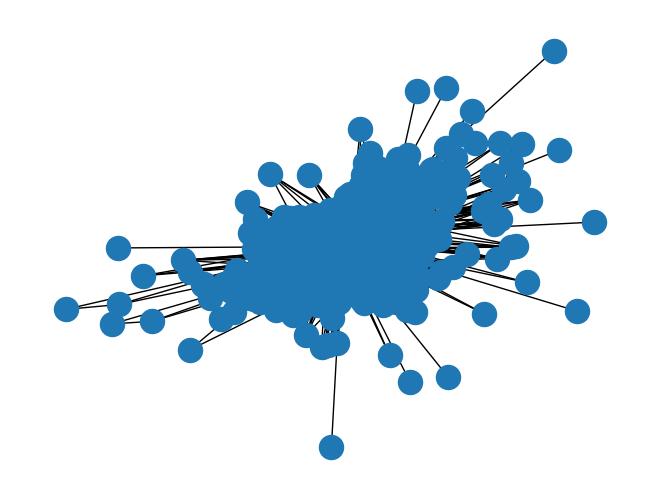

In [41]:
nx.draw(en_text_graph)

In [42]:
pickle.dump(en_text_graph, open('en_text_graph.gpickle', 'wb'))



In [43]:
es_text_graph = construct_text_similarity_network_en(es_data)
es_text_graph.size()

4633115

#### Note that a similarity threshold = 0.7 results in a giant graph with 4 million nodes for Spanish data. Will set a higher the threshold below

In [46]:
# English only
def construct_text_similarity_network_es(dataframe, threshold=0.85):
    # Step 1: Clean the text column
    dataframe['cleaned_text'] = dataframe['text'].apply(clean_text)
    
    # Step 2: Filter out tweets with fewer than 4 words
    dataframe = dataframe[dataframe['cleaned_text'].apply(lambda x: len(x.split()) >= 4)]
    
    # Step 3: Group tweets by user
    user_text_map = dataframe.groupby('id_str')['cleaned_text'].apply(list)
    user_text_map = {user: texts for user, texts in user_text_map.items() if len(texts) >= 10}

    # Step 4: Generate embeddings for each user
    user_embeddings = {}
    for i, (user, texts) in enumerate(user_text_map.items()):
        # Encode all texts for the user
        embeddings = model.encode(texts, device='cuda', batch_size=64)
        # Average embeddings to get a single user-level vector
        user_embeddings[user] = np.mean(embeddings, axis=0)

    # Step 5: Compute cosine similarity matrix
    user_ids = list(user_embeddings.keys())
    user_vectors = np.array(list(user_embeddings.values()))
    similarity_matrix = cosine_similarity(user_vectors)

    # Step 6: Build the user-user similarity graph
    G = nx.Graph()
    for i, user1 in enumerate(user_ids):
        for j, user2 in enumerate(user_ids):
            if i != j and similarity_matrix[i, j] > threshold:
                G.add_edge(user1, user2, weight=similarity_matrix[i, j])

    return G

In [47]:
es_text_graph = construct_text_similarity_network_es(es_data)
es_text_graph.size()

827789

In [48]:
pickle.dump(es_text_graph, open('es_text_graph.gpickle', 'wb'))

#### 3. Community detection 

In [53]:
from community import community_louvain

def cluster_graph(graph):
    # Apply Louvain clustering
    partition = community_louvain.best_partition(graph)
    nx.set_node_attributes(graph, partition, "community")
    return partition

# Cluster the networks
en_clusters = cluster_graph(en_text_graph)
es_clusters = cluster_graph(es_text_graph)

# Save cluster information
en_clusters_df = pd.DataFrame.from_dict(en_clusters, orient='index', columns=['community'])
es_clusters_df = pd.DataFrame.from_dict(es_clusters, orient='index', columns=['community'])


In [57]:
en_clusters_df.head(10)

,community
'1001490667338682368',0
'100838706',1
'1015829495616434176',1
'1017815060419407877',1
'1018723330063458304',1
'1021382089059590144',2
'1024424468742131713',0
'1032434966934814721',1
'1034480445960925184',2
'1039936018366058499',0


In [58]:
en_clusters_df.to_csv("en_text_sim_clusters_tfidf.csv")
es_clusters_df.to_csv("es_text_sim_clusters_tfidf.csv")